## MODEL DEPLOYMENT

Di notebook ini, saya akan men-deploy model terbaik yang saya dapatkan dari uji coba modelling di notebook sebelumnya, tetapi dengan adanya pencobaan tambahan update di hyperparameter agar model dapat bekerja lebih bagus.

Di notebook ini terdapat 2 model yang menurut saya paling bagus berdasarkan pilihan metricsnya:

1). Tuned Logistic Regression (Macro Precision)

2). Tuned Random forest Classifier SMOTE (Macro F1-score)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import kstest
from scipy.stats import mannwhitneyu, chi2_contingency
from yellowbrick.model_selection import LearningCurve

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning.space import Real, Integer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import pickle

SEED = 21
import warnings
warnings.filterwarnings('ignore')


/Users/steven/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
bank = pd.read_csv("bank_new.csv")

In [3]:
bank.head()

,age,job,marital,education,default,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,telephone,may,1,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
X = bank.drop("y", axis = 1)
y = bank["y"].map({"no" : 0, "yes" : 1})

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = SEED)

In [6]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["emp.var.rate", "euribor3m", "nr.employed", "cons.price.idx"]),
        ("cat", categorical_transformer, ["month", "poutcome", "job", "contact"])])


In [7]:
sm = SMOTE(random_state = SEED, sampling_strategy='minority')

## TUNED LOGISTIC REGRESSION (with updated hyperparameter)

In [8]:
log_model3 = Pipeline(steps=[('preprocessor2', preprocessor2),
                      ('logreg', LogisticRegression(C = 5.2, fit_intercept = True, 
                                                    random_state = SEED))])
log_model3.fit(X_train, y_train)
print(log_model3.score(X_train, y_train), log_model3.score(X_test, y_test))


0.9000728382643682 0.8986809096058914


In [9]:
log_pred2 = log_model3.predict(X_test)
log_proba2 = log_model3.predict_proba(X_test)

In [10]:
print(classification_report(y_test,log_pred2))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10955
           1       0.66      0.22      0.33      1402

    accuracy                           0.90     12357
   macro avg       0.79      0.60      0.64     12357
weighted avg       0.88      0.90      0.87     12357



Confusion Matrix 



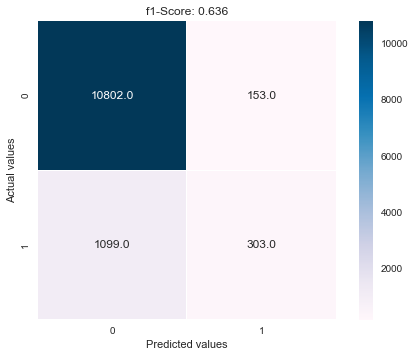

In [11]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, log_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, log_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [12]:
print("Matthew Score",matthews_corrcoef(y_test, log_pred2))

Matthew Score 0.3400850459614235


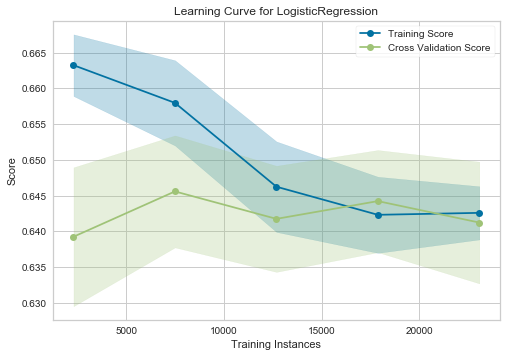

In [13]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    log_model3, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

## TUNED RANDOM CLASSIFIER SMOTE (with updated hyperparameter)

In [14]:
rfc_model4 = Pipeline(steps=[('preprocessor2', preprocessor2), ('sm', sm),
                      ('rfc', RandomForestClassifier(max_depth = 9, max_features = 0.31, 
                                                     min_samples_leaf = 3, n_estimators = 200, random_state = SEED))])

rfc_model4.fit(X_train, y_train)
print(rfc_model4.score(X_train, y_train), rfc_model4.score(X_test, y_test))


0.8626131594464292 0.8587844946184349


In [15]:
rfcsmote_pred2 = rfc_model4.predict(X_test)
rfcsmote_proba2 = rfc_model4.predict_proba(X_test)

In [16]:
print(classification_report(y_test,rfcsmote_pred2))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     10955
           1       0.42      0.61      0.49      1402

    accuracy                           0.86     12357
   macro avg       0.68      0.75      0.71     12357
weighted avg       0.89      0.86      0.87     12357



Confusion Matrix 



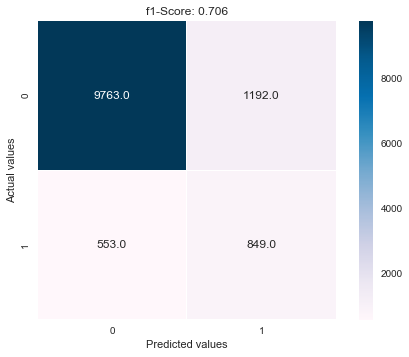

In [17]:
print("Confusion Matrix","\n")
score = round(f1_score(y_test, rfcsmote_pred2, average = "macro"),3) 
cm1 = confusion_matrix(y_test, rfcsmote_pred2)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = "PuBu")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.title("f1-Score: {0}".format(score), size = 12)
plt.show()
print("\n")

In [18]:
print("Matthew Score",matthews_corrcoef(y_test, rfcsmote_pred2))

Matthew Score 0.4242726424657398


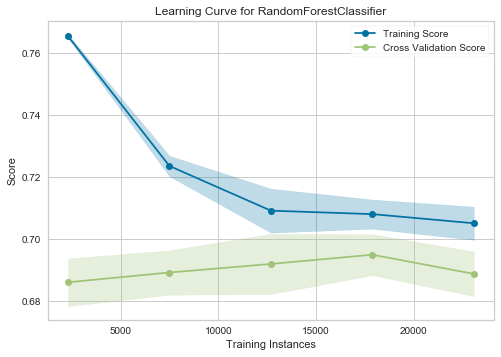

In [19]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_model4, scoring = 'f1_macro', train_size = sizes, random_state = SEED, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

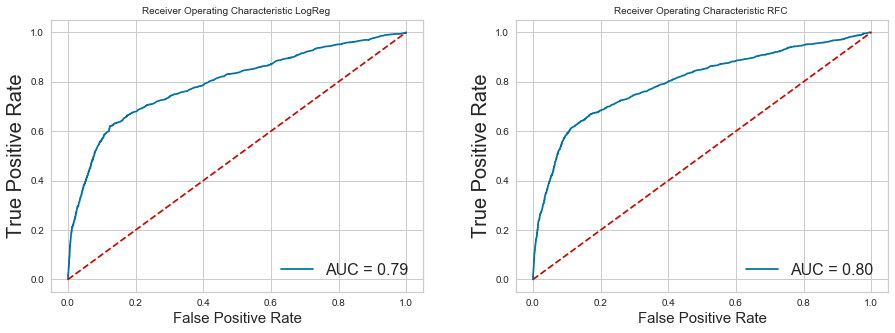

In [20]:
fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

## Tuned Logistic Regression (Updated)
logpreds = log_proba2[:,1]
fprlog, tprlog, thresholdlog = roc_curve(y_test, logpreds)
roc_auc_log = auc(fprlog, tprlog)

ax.plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auc_log)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic LogReg ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})


## Tuned Random Forest Classifier SMOTE (Updated)
rfcpred = rfcsmote_proba2[:,1]
fprrfc, tprrfc, thresholdrfc = roc_curve(y_test, rfcpred)
roc_auc_rfc = auc(fprrfc, tprrfc)

ax1.plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_auc_rfc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic RFC ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.25)

In [21]:
def Metric_evaluation(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred, average = 'macro'))
    precision.append(precision_score(y_test, y_pred, average = 'macro'))
    recall.append(recall_score(y_test, y_pred, average = 'macro'))
    matthews.append(matthews_corrcoef(y_test, y_pred)) 

def roc_auc(model):
    rocauc.append(model)

In [22]:
f1 = []
precision = []
recall = []
matthews = []
rocauc = []

In [23]:
Metric_evaluation(y_test, log_pred2)
Metric_evaluation(y_test, rfcsmote_pred2)

roc_auc(roc_auc_log)
roc_auc(roc_auc_rfc)


In [24]:
Metric_table = pd.DataFrame(index = [
                                    'Tuned Logistic Regression (Updated)',
                                    'Tuned Random Forest Classifier SMOTE (Updated)'
                                    ])

Metric_table['Macro F1-Score'] = f1
Metric_table['Macro Precision'] = precision
Metric_table['Macro Recall'] = recall
Metric_table['Matthews'] = matthews
Metric_table['ROG/AUC'] = rocauc

In [25]:
Metric_table

,Macro F1-Score,Macro Precision,Macro Recall,Matthews,ROG/AUC
Tuned Logistic Regression (Updated),0.635690,0.786064,0.601077,0.340085,0.793996
Tuned Random Forest Classifier SMOTE (Updated),0.705569,0.681183,0.748377,0.424273,0.798820


1). Utk Metric score Precision (Macro), dari antara semua model yang sudah dicoba, didapatkanlah bahwa model Tuned Logistic Regression (Updated) yang memiliki Precision (Macro) tertinggi.

2). Utk Metric score F1-score (Macro), dari antara semua model yang sudah dicoba, didapatkanlah bahwa 

## Pada akhirnya saya memilih utk memakai model Tuned Random Forest Classifier SMOTE (Updated) sebagai model terbaik utk deployment, dikarenakan saya ingin lebih fokus dengan F1-score (Macro)

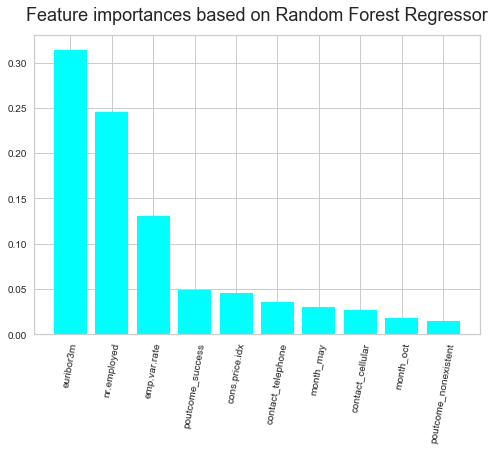

In [26]:
ranking = rfc_model4["rfc"].feature_importances_
features = np.argsort(ranking)[::-1][:10]
columns = pd.get_dummies(X_train[['emp.var.rate','euribor3m','nr.employed','cons.price.idx','month','poutcome',
                                 'job','contact']]).columns
plt.title("Feature importances based on Random Forest Regressor", y = 1.03, size = 18)
plt.bar(range(len(features)), ranking[features], color="aqua", align="center")
plt.xticks(range(len(features)), columns[features], rotation=80)
plt.show()


Feature dari Social and Economic context attribute adalah yang paling berpengaruh terhadap target kita. Ini masuk akal juga karena adanya korelasi yang lumayan tinggi antar fitur" tersebut.

Dengan begitu kita bisa merekomendasikan bank, utk lebih memperhatikan kondisi Social and Economic context attribute dalam membuat strategi marketing campaign.

### Pickle Dump

In [27]:
filename = 'randomforest.sav'
pickle.dump(rfc_model4, open(filename, 'wb'))

### Pickle Load

In [28]:
importModel = pickle.load(open('RandomForest.sav', 'rb'))

In [29]:
X_test.head()

,age,job,marital,education,default,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
29203,44,entrepreneur,married,university.degree,no,cellular,apr,2,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
4243,46,blue-collar,married,basic.4y,no,telephone,may,2,nonexistent,1.1,93.994,-36.4,4.856,5191.0
2953,33,technician,divorced,professional.course,no,telephone,may,4,nonexistent,1.1,93.994,-36.4,4.859,5191.0
39970,36,management,married,university.degree,no,cellular,jun,1,failure,-1.7,94.055,-39.8,0.761,4991.6
37999,76,retired,divorced,basic.4y,no,cellular,sep,1,nonexistent,-3.4,92.379,-29.8,0.788,5017.5


In [30]:
sample = pd.DataFrame({
    'age' : [42],
    'job' : ['admin.'],
    'marital' : ['married'],
    'education' : ['high.school'],
    'default' : ['no'],
    'contact' : ['telephone'],
    'month' : ['apr'],
    'campaign' : [12],
    'poutcome' : ['nonexistent'],
    'emp.var.rate' : [1.2],
    'cons.price.idx' : [95],
    'cons.conf.idx' : [-33.5],
    'euribor3m' : [2.5],
    'nr.employed' : [4586.2]
})

In [32]:
importModel.predict(X_test)


array([1, 0, 0, ..., 0, 0, 0])